# Laboratorio: Codificación de circuitos para la corrección cuántica de errores

## Objetivos

Con esta actividad desarrollarás un circuito cuántico completo de cifrado, descifrado y análisis y corrección de los mensajes.

## Descripción

Siguiendo un determinado algoritmo de cifrado, deberás desarrollar un circuito cuántico, utilizando IBM Quantum Experience, que lleve a cabo el cifrado, descifrado y análisis del síndrome. Se deberá probar el correcto funcionamiento del circuito con tres mensajes ejemplo en cada uno de los pasos.

## Desarrollo e Implementación

En este laboratorio se desarrollarán los siguientes algoritmos:

1. Código de Shor:

    El código de Shor es un código de corrección de errores que utiliza 8 qubits adicionales o ancilla para la detección y corrección de errores. Estos errores pueden ser tanto de bit flip,de fase o ambos. Debido al tipo de errores que corrige, el codigo de Shor es capaz de corregir cualquier error arbitrario $E$ en un qubit. Donde $E$ tiene la forma $E = c_0 I + c_1 X + c_2 Y + c_3 Z$. 

2. Código de Steane:

    El código de Stane es uno de los códigos de corrección de error más conocidos. Forma parte del conjunto de códigos CSS (Calderbank-Shor-Steane). Este código es capaz de corregir errores de bit flip y de fase. El código de Steane utiliza 7 qubits adicionales o ancilla para la detección y corrección de errores.

Para la implementación de los distintos protocolos se utilizará Qiskit, una biblioteca de Python para trabajar con circuitos cuánticos. Qiskit proporciona herramientas para crear y manipular circuitos cuánticos, así como para ejecutarlos en simuladores o dispositivos reales.

### Importación de librerías


In [1]:
import qiskit
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import XGate, ZGate, HGate, CXGate
import numpy as np
import matplotlib.pyplot as plt

### Código de Shor

El código de Shor corrige errores sobre un solo qubit. Es capaz de corregir el ruido más general posible en un qubit, es decir, cualquier error unitario arbitrario $E$ en un qubit. Donde $E$ tiene la forma $E = c_0 I + c_1 X + c_2 Y + c_3 Z$.

Este código esta diseñado de tal forma que los qubits 0, 3 y 6 son los qubits del código de corrección de cambio de fase, mientras que los grupos de qubits (0,1,2), (3,4,5) y (6,7,8) son los códigos de corrección de cambio de bit. Si ocurre un error de cambio de bit en un qubit, se analizará el síndrome en cada bloque de qubits (0,1,2), (3,4,5) y (6,7,8) para detectar y corregir, como máximo, un error de cambio de bit en cada uno de estos bloques. Si se considera a los 3 grupos (0,1,2), (3,4,5) y (6,7,8) como tres entradas distintas, entonces el circuito del código de Shor se puede interpretar como un código de cambio de fase. Esto significa que el código de Shor también puede corregir un error de cambio de fase en un solo qubit.

Como ya hemos anticipado, este código se basa en los códigos de 3 qubits de corrección de bit flip y de fase. En este caso la codificación empleada será la siguiente:

$$|0 \rangle \rightarrow |0_L \rangle = \frac{1}{2 \sqrt{2}}( |000 \rangle + |111 \rangle )( |000 \rangle + |111 \rangle )( |000 \rangle + |111 \rangle )$$

$$|1 \rangle \rightarrow |1_L \rangle = \frac{1}{2 \sqrt{2}}( |000 \rangle - |111 \rangle )( |000 \rangle - |111 \rangle )( |000 \rangle - |111 \rangle )$$

De esta forma nuestro estado inicial $| \psi \rangle = \alpha |0 \rangle + \beta |1 \rangle$ se codifica en el estado $| \psi_L \rangle = \alpha |0_L \rangle + \beta |1_L \rangle$.

El circuito de Shor se compone de los siguientes pasos:

#### 1. Codificación del mensaje.

En este paso se codifica el mensaje en el estado $| \psi_L \rangle$. Para ello primero se aplicaran puertas CNOT y Hadamard de manera que codifiquemos la inversión de fase. 

Las puertas CNOT se aplicarán sobre los qubit ancilla 3 y 6 controladas por el estado $| \psi \rangle$. Las puertas Hadamard se aplicarán sobre $|\psi \rangle$ y los qubits ancilla 3 y 6 nuevamente.

De esta forma obtenemos 

$$|0 \rangle \rightarrow |+++ \rangle $$
$$|1 \rangle \rightarrow |--- \rangle $$

Una vez codificados los errores en la fase, aplicaremos puertas CNOT en una estructura análoga a la utilizada en los códigos de 3 qubits. Estas puertas actuarán sobre los qubits ancilla 1, 2, 4, 5, 7 y 8. De esta forma codificamos los estados $|+ \rangle $ y $|-\rangle $.

$$|+ \rangle =  \frac{1}{\sqrt{2}}( |0 \rangle + |1 \rangle )\rightarrow \frac{1}{\sqrt{2}}( |000 \rangle + |111 \rangle  $$

$$|- \rangle =  \frac{1}{\sqrt{2}}( |0 \rangle - |1 \rangle )\rightarrow \frac{1}{\sqrt{2}}( |000 \rangle - |111 \rangle  $$

Obteniendo así la codificación deseada.

#### 2. Aplicación de errores.

En este paso podrá aplicarse un error arbitrario $E$ en cualquiera de los qubits del código. Modelizaremos este error mediante las puertas de Pauli $I$, $X$, $Y$ y $Z$.


En el siguiente esquema podemos observar la estructura general de estos primeros pasos.
<p align="center">
  <img src="Shor_code_inicio.png" alt="Esquema de la codificación del circuito de Shor">
</p>

#### 3. Decodificación del mensaje y corrección de errores.

En este paso se decodifica el mensaje aplicando las puertas inversas a las aplicadas en el paso 1. Este proceso se realizará por bloques, aplicando las correcciones necesarias en cada uno de ellos.

Para la corrección de errores de bit flip en los grupos de qubits (0,1,2), (3,4,5) y (6,7,8), decodificaremos el mensaje con aplicando de forma inversa la última serie de puertas CNOT de la codificación, para más tarde aplicar puertas CNOT sobre el primer qubit del grupo, controladas por los otros dos qubits del grupo. Esto corrige los posibles errores de bit flip en los qubits del grupo.

Para la corrección de errores de fase decodificaremos el mensaje de igual forma con el resto de puertas que hemos aplicado en un principio. Una vez decodificado el mensaje, aplicaremos la puerta CNOT sobre el qubit que contiene el mensaje $|\psi \rangle$ controlada por los qubits ancilla 3 y 6. De esta forma corregiremos los posibles errores de fase.

En el siguiente esquema podemos observar la estructura general del circuito de Shor.

<p align="center">
  <img src="Shor_code.png" alt="Esquema del circuito de Shor">
</p>






In [2]:

def shor_error_correction(initial_state = Statevector.from_label('0'), error_qubit = 0, error_type = 'Bit Flip'):

    """
    Aplica la corrección de errores de Shor en un circuito cuántico.

    Parámetros:
    - initial_state (list or ndarray): El vector de estado inicial del sistema cuántico.
    - error_qubit (int, opcional): El qubit en el cual se aplicará el error. Por defecto es 0.
    - error_type (str, opcional): El tipo de error que se aplicará.
                                  Opciones: 'Bit Flip', 'Phase Flip', 'Both'. Por defecto es 'Bit Flip'.

    Retorna:
    QuantumCircuit: Circuito cuántico con la corrección de errores de Shor aplicada.

    Lanza:
    - ValueError: Si error_qubit no está en el rango [0, 8] o si error_type no es uno de ['Bit Flip', 'Phase Flip', 'Both'].

    Uso:
    initial_state = random_statevector(2).data  # Ejemplo de un estado inicial aleatorio
    error_qubit = 5  # Ejemplo de qubit donde ocurre el error
    error_type = 'Both'  # Ejemplo del tipo de error
    circuito_corregido = shor_error_correction(initial_state, error_qubit, error_type)
    circuito_corregido.draw(output='mpl')
    """
   
    # Comprobamos que el qubit de error esté en el rango correcto
    if not (0 <= error_qubit <= 8):
        raise ValueError("Error: error_qubit must be between 0 and 8")

    # Comprobamos que el tipo de error sea válido
    error_types_disponibles = ['Bit Flip', 'Phase Flip', 'Both','None']
    if error_type not in error_types_disponibles:
        raise ValueError(f"Error: error_type must be one of {error_types_disponibles}")
    
    # Creamos el registro de nuestro qubit de estado
    state = qiskit.QuantumRegister(1, 'state')

    # Creamos el registro de los 8 qubits de soporte
    support = qiskit.QuantumRegister(8, 'q')

    # Creamos el circuito cuántico
    circuit = QuantumCircuit(state, support)

    # Inicializamos el estado cuántico
    circuit.initialize(initial_state, 0)

    # Gurardamos el estado inicial

    # Bloque corrección de errores de fase
    # CNOTs
    circuit.cnot(0, 3)
    circuit.cnot(0, 6)

    # Hadamard sobre los qubits implicados en las primeras CNOTs
    circuit.h(0)
    circuit.h(3)
    circuit.h(6)

    # Bloque de corrección de errores de bit flip
    # CNOTs para cada triplete de qubits
    circuit.cnot(0, 1)
    circuit.cnot(3, 4)
    circuit.cnot(6, 7)

    circuit.cnot(0, 2)
    circuit.cnot(3, 5)
    circuit.cnot(6, 8)

    # Implementación del error en el qubit especificado
    circuit.barrier()
    if error_type == 'Bit Flip':
        circuit.x(error_qubit)
    elif error_type == 'Phase Flip':
        circuit.z(error_qubit)
    elif error_type == 'Both':
        circuit.z(error_qubit)
        circuit.x(error_qubit)
    elif error_type == 'None':
        pass
    circuit.barrier()
    
    # Corrección de errores de bit flip
    circuit.cnot(0, 1)
    circuit.cnot(3, 4)
    circuit.cnot(6, 7)

    circuit.cnot(0, 2)
    circuit.cnot(3, 5)
    circuit.cnot(6, 8)

    # Análisis del síndrome de bit flip
    circuit.ccx(2, 1, 0)
    circuit.ccx(5, 4, 3)
    circuit.ccx(8, 7, 6)

    # Corrección de errores de fase
    circuit.h(0)
    circuit.h(3)
    circuit.h(6)

    circuit.cnot(0, 3)
    circuit.cnot(0, 6)

    # Análisis del síndrome de fase
    circuit.ccx(6, 3, 0)

    return circuit

La función `shor_error_correction` implementa el código de Shor. Esta función toma como entrada el estado $|\psi \rangle$ y el error $E$ que se le aplicará y el qubit donde sucede dicho error. La función devuelve el código de corrección de errores de Shor aplicado al estado $|\psi \rangle$ con el error $E$ aplicado en el qubit correspondiente.

Con la función ya desarrollada, definiremos un primer caso y comprobaremos su funcionamiento. Esta primera prueba tomará los siguientes parámetros:

- $|\psi \rangle = |1 \rangle$
- $E = X$
- Qubit donde se aplica el error: 0


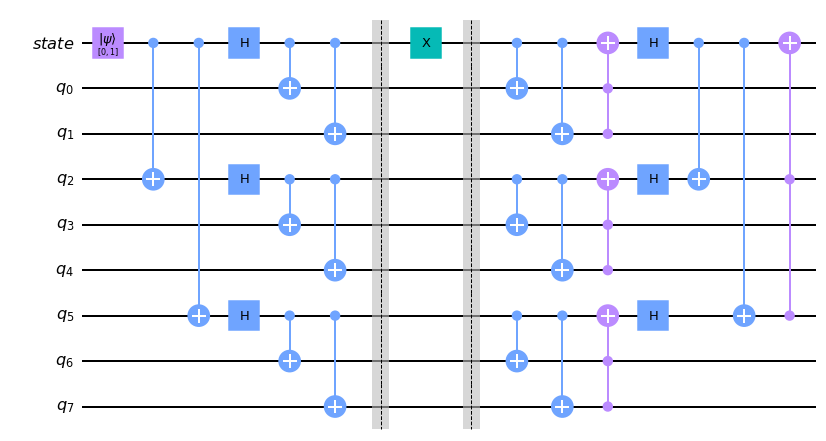

In [3]:
# Ejemplo
initial_state = Statevector.from_label('1')  # Cambia esto según tu estado inicial
error_qubit = 0  # Cambia esto según el qubit en el que ocurre el error
error_type = 'Bit Flip'  # Cambia esto según el tipo de error

circuit = shor_error_correction(initial_state, error_qubit, error_type)
circuit.draw(output='mpl')

Podemos ver el código de Shor para dicho caso en el circuito que tenemos justo encima. Definido el circuito lo ejecutaremos y verificaremos que el estado final del qubit 0 es $|1 \rangle$.

Ejecutaremos el circuito en el simulador `statevector_simulator` de Qiskit, el cual nos permitirá recuperar el estado al final de la ejecución del circuito. 

In [4]:
# Ejecución del circuito

#Definimos el backend
backend = Aer.get_backend('statevector_simulator')

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

Representaremos el estado final del circuito, donde el qubit asociado al estado $|\psi \rangle$ será el qubit 0, es decir, el menos significativo.

In [5]:
# Obtenemos el estado final
outputstate = result.get_statevector(circuit)
outputstate.draw('latex')

<IPython.core.display.Latex object>

Podemos observar que efectivamente el estado final del qubit 0 es $|1 \rangle$, por lo que el circuito ha funcionado correctamente.

Para confirmar su correcto funcionamiento realizaremos dos pruebas más con los siguientes parámetros:

Prueba 2:
- $|\psi \rangle = |+ \rangle$
- $E = Y$
- Qubit donde se aplica el error: 3


Prueba 3:
- $|\psi \rangle = |0 \rangle$
- $E = Z$
- Qubit donde se aplica el error: 6


In [6]:
# Ejemplo
initial_state = Statevector.from_label('+')  # Cambia esto según tu estado inicial
error_qubit = 3  # Cambia esto según el qubit en el que ocurre el error
error_type = 'Both'  # Cambia esto según el tipo de error

circuit = shor_error_correction(initial_state, error_qubit, error_type)


# Ejecución del circuito
#Definimos el backend
backend = Aer.get_backend('statevector_simulator')

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

# Obtenemos el estado final
outputstate = result.get_statevector(circuit)
outputstate.draw('latex')

<IPython.core.display.Latex object>

In [7]:
# Ejemplo
initial_state = Statevector.from_label('0')  # Cambia esto según tu estado inicial
error_qubit = 6  # Cambia esto según el qubit en el que ocurre el error
error_type = 'Phase Flip'  # Cambia esto según el tipo de error

circuit = shor_error_correction(initial_state, error_qubit, error_type)


# Ejecución del circuito
#Definimos el backend
backend = Aer.get_backend('statevector_simulator')

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

# Obtenemos el estado final
outputstate = result.get_statevector(circuit)
outputstate.draw('latex')

<IPython.core.display.Latex object>

Podemos concluir que el código de Shor implementado funciona correctamente.

### Código de Steane

En esta sección se implementará el código de Steane. Este código es conocido como el código [[7,1,3]], lo que significa que protege un qubit lógico contra un cambio de bit y un cambio de fase utilizando 7 qubits físicos. El código de Steane está basado en un código de corrección de errores clásico llamado código de Hamming; es esencialmente su equivalente cuántico. El código de Stane utiliza 6 qubits ancilla para la detrcción y corrección de errores 3 para la detección de cambio de bit y 3 para la detección de cambio de fase.

Como en el caso del código de Shor, el c´digo de Steane se compone de los siguientes pasos:

#### 1. Codificación del mensaje.

El código de Steane representará los qubits lógicos $|0_L \rangle$ y $|1_L \rangle$ de la siguiente forma:

$$|0 \rangle \rightarrow |0_L \rangle = \frac{1}{\sqrt{8}} (|0000000\rangle + |1101001\rangle + |1011010\rangle + |0110011\rangle + |0111100\rangle + |1010101\rangle + |1100110\rangle + |0001111\rangle)$$

$$|1 \rangle \rightarrow |1_L \rangle = \frac{1}{\sqrt{8}} (|1110000\rangle + |0011001\rangle + |0101010\rangle + |1000011\rangle + |1001100\rangle + |0100101\rangle + |0010110\rangle + |1111111\rangle)$$

Para realizar esta codificación haremos uso de puertas CNOT y Hadamard. En la siguiente imagen podemos observar el circuito de codificación de Steane.

<p align="center">
  <img src="Steane_code_Inicio.png" alt="Esquema del circuito de Steane">
</p>

#### 2. Aplicación de errores.

Una vez codificado el mensaje, podrá aplicarse un error arbitrario $E$ en cualquiera de los qubits del código. Modelizaremos este error mediante las puertas de Pauli $I$, $X$, $Y$ y $Z$.

#### 3. Decodificación del mensaje y corrección de errores.

Para la decodificación del mensaje y la corrección de errores utilizaremos un canal clásico de 6 bits y 6 qubits extra sobre los que realizar mediciones. Estas mediciones generarán un síndrome que nos permitirá detectar y corregir los errores. Utilizaremos los 3 primeros qubits auxiliares para la detección de errores de cambio de bit y los 3 últimos para la detección de errores de cambio de fase.

El circuito de generación del síndrome es el siguiente:

<p align="center">
  <img src="Steane_code.png" alt="Esquema del circuito de Steane">
</p>

Los resultados obtenidos en las lecturas de los síndromes nos permitirán la corrección del error. La tabla de sindromes es la siguiente para el cambio de bit:

| Índice del Qubit Roto | `bit_0` | `bit_1` | `bit_2` |
| --- | --- | --- | --- |
| Ninguno | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 |
| 1 | 0 | 1 | 0 |
| 2 | 0 | 1 | 1 |
| 3 | 1 | 0 | 0 |
| 4 | 1 | 0 | 1 |
| 5 | 1 | 1 | 0 |
| 6 | 1 | 1 | 1 |

Para el cambio de fase la tabla de síndromes es análoga.

Podemos darnos cuenta que los qubits del síndrome básicamente representan la codificación binaria del índice del qubit con error. 

Una vez obtenido el síndrome, aplicaremos las correcciones necesarias en función de los resultados obtenidos.

In [8]:
def steane_code(initial_state = Statevector.from_label('0'), error_qubit = 0, error_type = 'Bit Flip'):

    """
    Implementa el código de corrección de errores de Steane en un circuito cuántico.

    Parámetros:
    - initial_state (str): Estado inicial del qubit codificado.
    - error_qubit (int): Índice del qubit al que se le aplicará el error.
    - error_type (str): Tipo de error a aplicar ('Bit Flip', 'Phase Flip', 'Both', 'None').

    Retorna:
    - QuantumCircuit: Circuito cuántico implementando el código de Steane.

    Lanza:
    - ValueError: Si el índice del qubit de error está fuera del rango [0, 6] o si error_type no es válido.

    Uso:
    - circuit = steane_code(Statevector.from_label('1'), error_qubit=3, error_type='Bit Flip')
    - job = execute(circuit, backend)
    - result = job.result()
    - counts = result.get_counts()

    """

        # Comprobamos que el qubit de error esté en el rango correcto
    if not (0 <= error_qubit <= 6):
        raise ValueError("Error: error_qubit must be between 0 and 6")

    # Check if error_type is one of the allowed values
    error_types_disponibles = ['Bit Flip', 'Phase Flip', 'Both','None']
    if error_type not in error_types_disponibles:
        raise ValueError(f"Error: error_type must be one of {error_types_disponibles}")

    
    # Creamos el registro de nuestro qubit de estado
    state = qiskit.QuantumRegister(1, 'state')

    # Creamos el registro de los 8 qubits de soporte
    support = qiskit.QuantumRegister(6, 'q')

    # Creamos el registro de los qubits de ancilla
    ancilla = qiskit.QuantumRegister(6, 'ancilla')

    # Creamos los registros clásicos

    classical = qiskit.ClassicalRegister(7)

    # Creamos el circuito cuántico
    circuit = QuantumCircuit(state, support, ancilla, classical)

    # Inicializamos el estado cuántico
    circuit.initialize(initial_state, 0)
    
    circuit.barrier()


    # Hadamard sobre los primeros qubits
    circuit.h(4)
    circuit.h(5)
    circuit.h(6)

    # CNOTs
    circuit.cx(0, 1)
    circuit.cx(0, 2)

    circuit.cx(6, 0)
    circuit.cx(6, 1)
    circuit.cx(6, 3)

    circuit.cx(5, 0)
    circuit.cx(5, 2)
    circuit.cx(5, 3)
    

    circuit.cx(4, 1)
    circuit.cx(4, 2)
    circuit.cx(4, 3)

    # Implementación del error en el qubit especificado
    circuit.barrier()
    if error_type == 'Bit Flip':
        circuit.x(error_qubit)
    elif error_type == 'Phase Flip':
        circuit.z(error_qubit)
    elif error_type == 'Both':
        circuit.z(error_qubit)
        circuit.x(error_qubit)
    elif error_type == 'None':
        pass     
    circuit.barrier()

    # Corrección de errores 
    circuit.cx(4,3)
    circuit.cx(4,2)
    circuit.cx(4,1)

    circuit.cx(5,3)
    circuit.cx(5,2)
    circuit.cx(5,0)

    circuit.cx(6,3)
    circuit.cx(6,1)
    circuit.cx(6,0)

    circuit.cx(0,2)
    circuit.cx(0,1)


    # Hadamard sobre los primeros qubits
    circuit.h(6)
    circuit.h(5)
    circuit.h(4)

    circuit.barrier()

    # Detección Bit Flip
    circuit.cx(0, 7)
    circuit.cx(2, 7)
    circuit.cx(4, 7)
    circuit.cx(6, 7)
    circuit.cx(1, 8)
    circuit.cx(2, 8)
    circuit.cx(5, 8)
    circuit.cx(6, 8)

    circuit.cx(3, 9)
    circuit.cx(4, 9)
    circuit.cx(5, 9)
    circuit.cx(6, 9)

    # Detección Phase Flip
    circuit.h(10)
    circuit.h(11)
    circuit.h(12)

    circuit.cx(10, 0)
    circuit.cx(10, 2)
    circuit.cx(10, 4)
    circuit.cx(10, 6)

    circuit.cx(11, 1)
    circuit.cx(11, 2)
    circuit.cx(11, 5)
    circuit.cx(11, 6)

    circuit.cx(12, 3)
    circuit.cx(12, 4)
    circuit.cx(12, 5)
    circuit.cx(12, 6)

    circuit.h(10)
    circuit.h(11)
    circuit.h(12)

    circuit.barrier()

    # Medición
    circuit.measure(7, 0)
    circuit.measure(8, 1)
    circuit.measure(9, 2)
    circuit.measure(10, 3)
    circuit.measure(11, 4)
    circuit.measure(12, 5)

    # Corrección de errores de bit flip
    # Iterar sobre todos los números del 1 al 6
    for i in range(1, 6):
        binary_str = format(i, '03b')  # Convertir el número a binario y llenar con ceros a la izquierda
        
        # Aplicar las puertas cuánticas según el valor binario
        with circuit.if_test((classical[2], int(binary_str[0]))) as _else:
            with circuit.if_test((classical[1], int(binary_str[1]))) as _else:
                with circuit.if_test((classical[0], int(binary_str[2]))) as _else:
                        # Asignar la puerta cuántica correspondiente al número
                    if binary_str == '001':
                            circuit.x(0)
                    elif binary_str == '010':
                            circuit.x(1)
                    elif binary_str == '011':
                            circuit.x(2)
                    elif binary_str == '100':
                            circuit.x(3)
                    elif binary_str == '101':
                            circuit.x(4)
                    elif binary_str == '110':
                            circuit.x(5)
                    elif binary_str == '111':
                            circuit.x(6)
    circuit.barrier()

    # Corrección de errores de fase
    # Iterar sobre todos los números del 1 al 6    
    for i in range(1, 6):
        binary_str = format(i, '03b')
        # Aplicar las puertas cuánticas según el valor binario

        with circuit.if_test((classical[5], int(binary_str[0]))) as _else:
            with circuit.if_test((classical[4], int(binary_str[1]))) as _else:
                with circuit.if_test((classical[3], int(binary_str[2]))) as _else:
                    # Asignar la puerta cuántica correspondiente al número
                    if binary_str == '001':
                            circuit.x(0)
                    elif binary_str == '010':
                            circuit.x(1)
                    elif binary_str == '011':
                            circuit.x(2)
                    elif binary_str == '100':
                            circuit.x(3)
                    elif binary_str == '101':
                            circuit.x(4)
                    elif binary_str == '110':
                            circuit.x(5)
                    elif binary_str == '111':
                            circuit.x(6)

    circuit.barrier()

    # Medimos el estado final
    circuit.measure(0, 6)
    return circuit

La función `steane_error_correction` implementa el código de Steane. Esta función toma como entrada el estado $|\psi \rangle$ y el error $E$ que se le aplicará y el qubit donde sucede dicho error. La función devuelve el código de corrección de errores de Steane aplicado al estado $|\psi \rangle$ con el error $E$ aplicado en el qubit correspondiente.

Con la función ya desarrollada, definiremos un primer caso y comprobaremos su funcionamiento. Esta primera prueba tomará los siguientes parámetros:

- $|\psi \rangle = |1 \rangle$
- $E = X$
- Qubit donde se aplica el error: 0

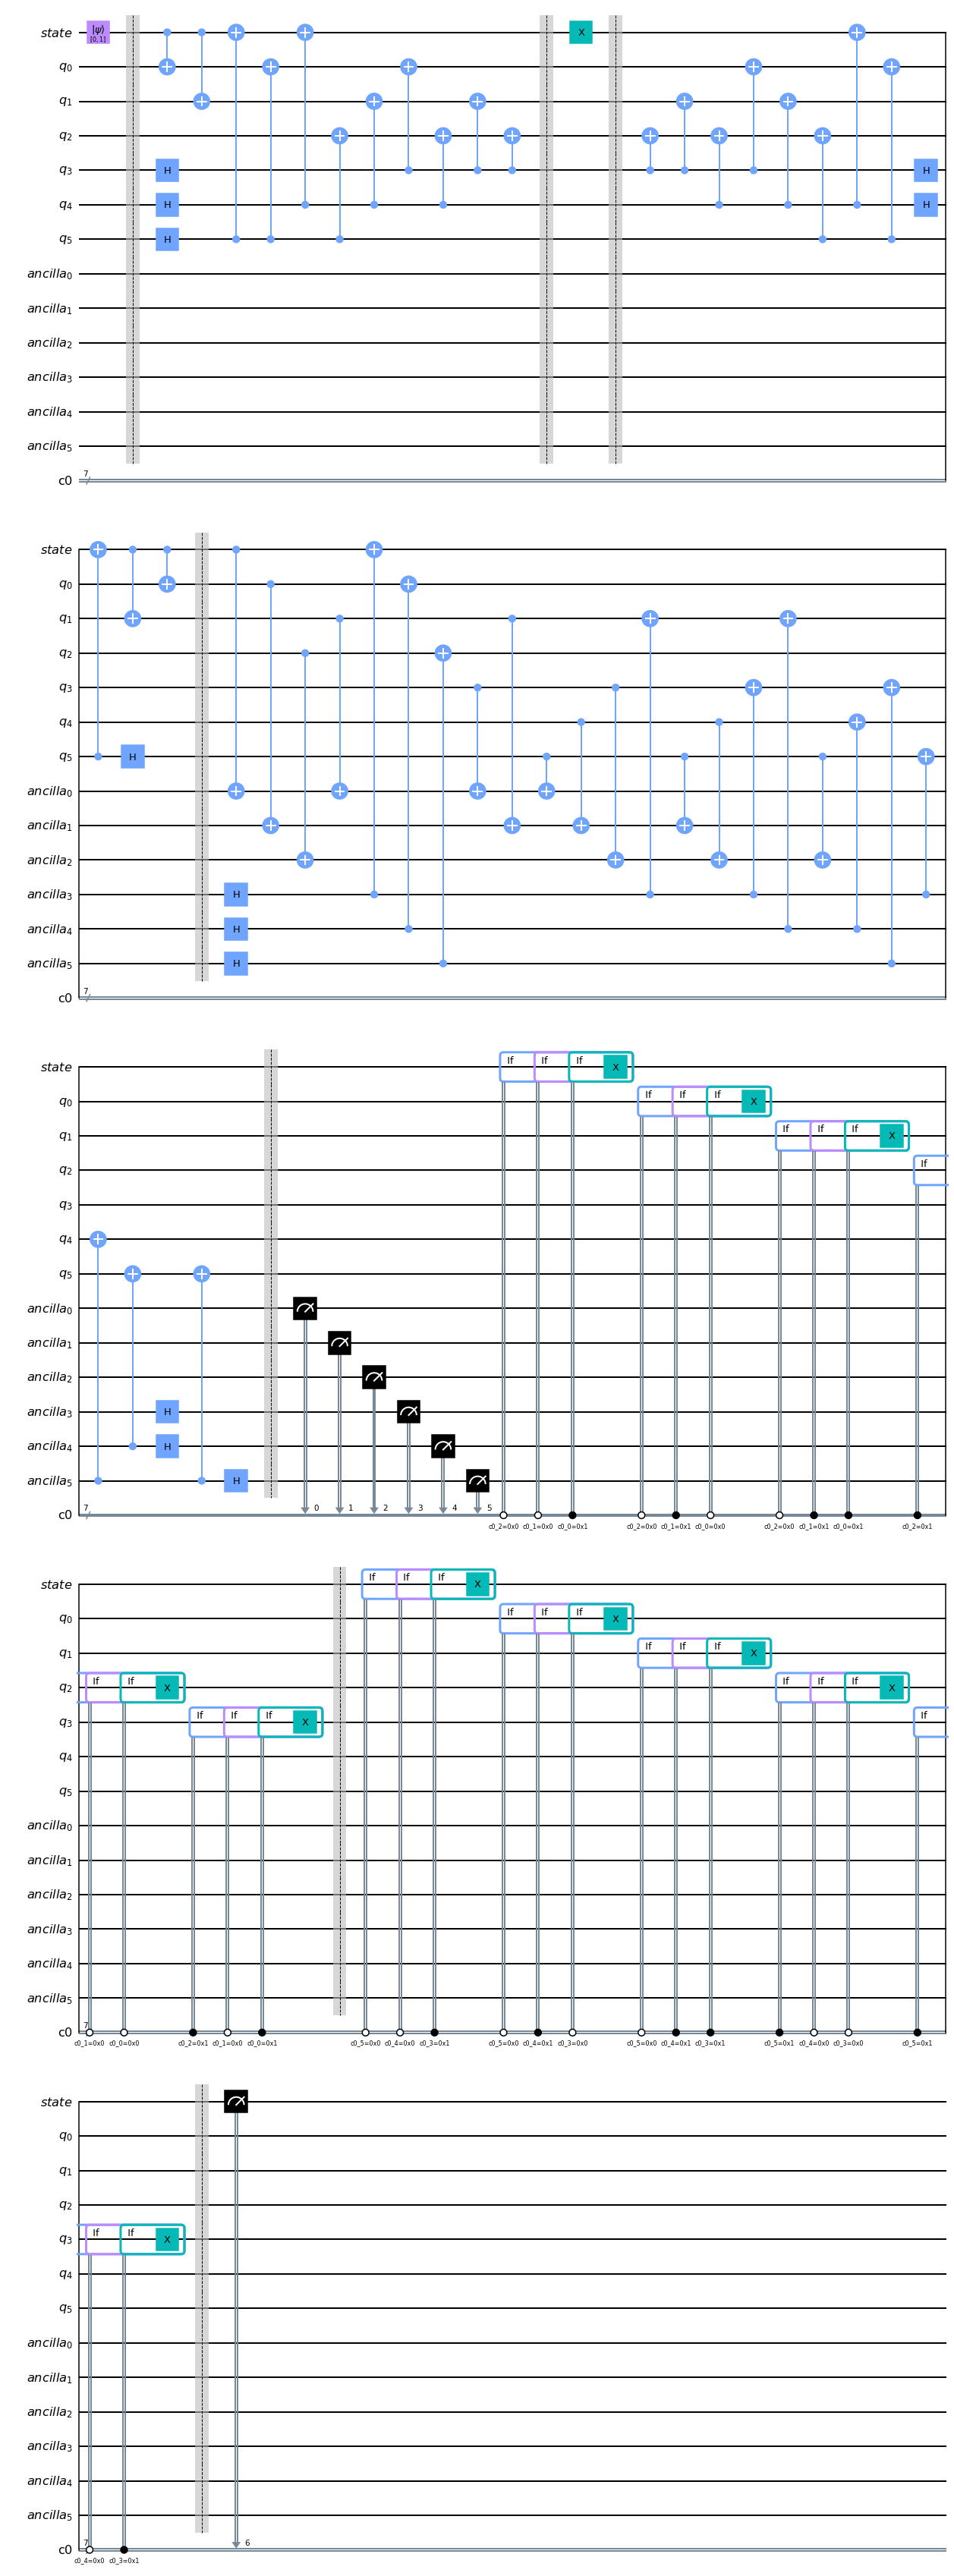

In [9]:
# Ejemplo
initial_state = Statevector.from_label('1')  # Cambia esto según tu estado inicial
error_qubit = 0 # Cambia esto según el qubit en el que ocurre el error
error_type = 'Bit Flip'  # Cambia esto según el tipo de error

circuit = steane_code(initial_state, error_qubit, error_type)
circuit.draw(output='mpl')

Podemos ver el código de Steane para dicho caso en el circuito que tenemos justo encima. Definido el circuito lo ejecutaremos y verificaremos que el estado final del qubit 0 es $|1 \rangle$.

Ejecutaremos el circuito en el simulador `aer_simulator` de Qiskit, el cual nos permitirá ejecutar puertas de forma condicional. Para verificar los resultados recuperaremos los conteos obtenidos para la medida del estado final del circuito.

Compararemos el qubit 0 con el estado enviado. 

In [10]:
# Ejecución del circuito

#Definimos el backend
backend = Aer.get_backend('aer_simulator',shots=1024)

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

Recuperamos los conteos para el qubit 0 del circuito y observamos que efectivamente el estado final del qubit 0 es $|1 \rangle$, por lo que el circuito ha funcionado correctamente.

In [11]:
# Obtenemos la medida del estado final
counts = result.get_counts(circuit)

# Diccionario para el estado final
final_state = {}

# Iterar sobre el diccionario de counts
for key, value in counts.items():

    # Obtener el último caracter
    last_num = key[-1]

    # Agregar al diccionario del último caracter
    final_state[last_num] = final_state.get(last_num, 0) + value

print("\nEstado recibido:")
print(final_state)


Estado recibido:
{'1': 1024}


Para confirmar su correcto funcionamiento realizaremos dos pruebas más con los siguientes parámetros:

Prueba 2:
- $|\psi \rangle = |+ \rangle$
- $E = X$
- Qubit donde se aplica el error: 4

Prueba 3:
- $|\psi \rangle = |- \rangle$
- $E = Z$
- Qubit donde se aplica el error: 2

In [12]:
# Ejemplo
initial_state = Statevector.from_label('+').data  # Cambia esto según tu estado inicial
error_qubit = 4 # Cambia esto según el qubit en el que ocurre el error
error_type = 'Bit Flip'  # Cambia esto según el tipo de error
circuit = steane_code(initial_state, error_qubit, error_type)

# Ejecución del circuito

#Definimos el backend
backend = Aer.get_backend('aer_simulator',shots=1024)

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

# Obtenemos la medida del estado final
counts = result.get_counts(circuit)

# Diccionario para el estado final
final_state = {}

# Iterar sobre el diccionario de counts
for key, value in counts.items():

    # Obtener el último caracter
    last_num = key[-1]

    # Agregar al diccionario del último caracter
    final_state[last_num] = final_state.get(last_num, 0) + value

print("\nEstado recibido:")
print(final_state)


Estado recibido:
{'1': 515, '0': 509}


In [17]:
# Ejemplo
initial_state = Statevector.from_label('-').data  # Cambia esto según tu estado inicial
error_qubit = 2 # Cambia esto según el qubit en el que ocurre el error
error_type = 'Phase Flip'  # Cambia esto según el tipo de error
circuit = steane_code(initial_state, error_qubit, error_type)

# Ejecución del circuito

#Definimos el backend
backend = Aer.get_backend('aer_simulator',shots=1024)

#Ejecutamos el circuito
job = execute(circuit, backend)
result = job.result()

# Obtenemos la medida del estado final
counts = result.get_counts(circuit)

# Diccionario para el estado final
final_state = {}

# Iterar sobre el diccionario de counts
for key, value in counts.items():

    # Obtener el último caracter
    last_num = key[-1]

    # Agregar al diccionario del último caracter
    final_state[last_num] = final_state.get(last_num, 0) + value

print("\nEstado recibido:")
print(final_state)


Estado recibido:
{'1': 505, '0': 519}


Con los resultados obtenidos podemos concluir que el código de Steane implementado funciona correctamente.

### Código de 5 qubits

DEFINICIÓN DEL ALGORITMO DE 5 QUBITS Y SUS PASOS

In [14]:
def five_qubit_error_correction(initial_state, error_qubit = 0, error_type = 'Bit Flip'):

        # Comprobamos que el qubit de error esté en el rango correcto
    if not (0 <= error_qubit <= 4):
        raise ValueError("Error: error_qubit must be between 0 and 8")

    # Check if error_type is one of the allowed values
    error_types_disponibles = ['Bit Flip', 'Phase Flip', 'Both']
    if error_type not in error_types_disponibles:
        raise ValueError(f"Error: error_type must be one of {error_types_disponibles}")

    
    # Creamos el registro de nuestro qubit de estado
    state = qiskit.QuantumRegister(1, 'state')

    # Creamos el registro de los 8 qubits de soporte
    support = qiskit.QuantumRegister(4, 'q')

    # Creamos el registro de los 4 qubits de soporte
    classical = qiskit.ClassicalRegister(4, 'c')

    # Creamos el circuito cuántico
    circuit = QuantumCircuit(state, support, classical)

    # Inicializamos el estado cuántico
    circuit.initialize(initial_state, 0)

    circuit.barrier()

    # Puertas de Hadamard

    circuit.h(1)
    circuit.h(2)
    circuit.h(3)

    # Controlled - gates
    circuit.h(4)
    c3x_gate = XGate().control(3)
    circuit.append(c3x_gate, [0, 2, 3, 4])
    circuit.h(4)

    circuit.h(4)
    c3x_gate = XGate().control(3, ctrl_state='001')
    circuit.append(c3x_gate, [0, 1, 3, 4])
    circuit.h(4)

    circuit.cx(0,4)
    circuit.cx(1,0)
    circuit.cx(1,4)
    circuit.cx(3,0)
    circuit.cx(2,4)

    circuit.h(0)
    c2x_gate = XGate().control(2)
    circuit.append(c2x_gate, [3, 4, 0])
    circuit.h(0)
    
    # Implementación del error en el qubit especificado
    circuit.barrier()
    if error_type == 'Bit Flip':
        circuit.x(error_qubit)
    elif error_type == 'Phase Flip':
        circuit.z(error_qubit)
    elif error_type == 'Both':
        circuit.z(error_qubit)
        circuit.x(error_qubit)
    circuit.barrier()
    
    # Generación del síndrome
    circuit.h(0)
    c2x_gate = XGate().control(2)
    circuit.append(c2x_gate, [3, 4, 0])
    circuit.h(0)

    circuit.cx(2,4)
    circuit.cx(3,0)
    circuit.cx(1,4)
    circuit.cx(1,0)
    circuit.cx(0,4)
    
    circuit.h(4)
    c3x_gate = XGate().control(3, ctrl_state='001')
    circuit.append(c3x_gate, [0, 1, 3, 4])
    circuit.h(4)
    
    circuit.h(4)
    c3x_gate = XGate().control(3)
    circuit.append(c3x_gate, [0, 2, 3, 4])
    circuit.h(4)

    
    
    circuit.h(3)
    circuit.h(2)
    circuit.h(1)

    circuit.barrier()

    # Si la medida de los qubits de soporte es 0, no hay error
    # Si la medida de los qubits de soporte es 0001 aplicamos una Z al qubit 0

    circuit.measure([1,2,3,4], [0,1,2,3])

    circuit.barrier()
    
    # Corrección de errores
    # Iterar sobre todos los números del 1 al 15
    for i in range(1, 16):
        binary_str = format(i, '04b')  # Convertir el número a binario y llenar con ceros a la izquierda
        
        # Aplicar las puertas cuánticas según el valor binario
        with circuit.if_test((classical[0], int(binary_str[0]))):
            with circuit.if_test((classical[1], int(binary_str[1]))):
                with circuit.if_test((classical[2], int(binary_str[2]))):
                    with circuit.if_test((classical[3], int(binary_str[3]))):
                        # Asignar la puerta cuántica correspondiente al número
                        if binary_str == '0001':
                            circuit.x(0)
                        elif binary_str == '0010':
                            circuit.y(2)
                        elif binary_str == '0011':
                            circuit.x(4)
                        elif binary_str == '0100':
                            circuit.z(4)
                        elif binary_str == '0101':
                            circuit.z(1)
                        elif binary_str == '0110':
                            circuit.x(3)
                        elif binary_str == '0111':
                            circuit.y(4)
                        elif binary_str == '1000':
                            circuit.x(1)
                        elif binary_str == '1001':
                            circuit.z(3)
                        elif binary_str == '1010':
                            circuit.z(0)
                        elif binary_str == '1011':
                            circuit.y(0)
                        elif binary_str == '1100':
                            circuit.x(2)
                        elif binary_str == '1101':
                            circuit.y(1)
                        elif binary_str == '1110':
                            circuit.y(2)
                        elif binary_str == '1111':
                            circuit.y(3)


    return circuit
